In [186]:
import pandas as pd
import concurrent.futures
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings

In [141]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, euclidean_distances
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from multiprocessing import Pool
from joblib import Parallel, delayed
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.api import VAR
from scipy.spatial.distance import euclidean

In [142]:
warnings.filterwarnings("ignore")

In [143]:
#парсим тикеры sp500
def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500 = table[0]
    tickers = sp500['Symbol'].tolist()
    return tickers

sp500_tickers = get_sp500_tickers()

In [144]:
#загружаем котировки за 5 лет и сохраняем в csv
'''
all_data = pd.DataFrame()
ticker_symbols = sp500_tickers

def download_stock_data(symbol):
    try:
        data = yf.Ticker(symbol).history(period="5y")
        data['Ticker'] = symbol  # здесь указать тикер
        return data
    except Exception as e:
        print(f"Failed download: [{symbol}]: {e}")
        return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(download_stock_data, symbol) for symbol in ticker_symbols]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(ticker_symbols), desc="Downloading"):
        data = future.result()
        if data is not None:
            all_data = pd.concat([all_data, data], axis=0)
'''

'\nall_data = pd.DataFrame()\nticker_symbols = sp500_tickers\n\ndef download_stock_data(symbol):\n    try:\n        data = yf.Ticker(symbol).history(period="5y")\n        data[\'Ticker\'] = symbol  # здесь указать тикер\n        return data\n    except Exception as e:\n        print(f"Failed download: [{symbol}]: {e}")\n        return None\n\nwith concurrent.futures.ThreadPoolExecutor() as executor:\n    futures = [executor.submit(download_stock_data, symbol) for symbol in ticker_symbols]\n    for future in tqdm(concurrent.futures.as_completed(futures), total=len(ticker_symbols), desc="Downloading"):\n        data = future.result()\n        if data is not None:\n            all_data = pd.concat([all_data, data], axis=0)\n'

In [145]:
#all_data.to_csv("yfinance_data.csv") 

In [146]:
all_data = pd.read_csv("yfinance_data.csv") 

In [147]:
all_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Adj Close
0,2018-12-04 00:00:00-05:00,159.400442,161.229428,157.130944,157.245865,3108900.0,0.0,0.0,ACN,NaN
1,2018-12-06 00:00:00-05:00,153.894273,154.880589,149.996875,152.496185,6012000.0,0.0,0.0,ACN,NaN
2,2018-12-07 00:00:00-05:00,152.141883,153.961298,149.613846,150.772522,3090000.0,0.0,0.0,ACN,NaN
3,2018-12-10 00:00:00-05:00,150.360787,151.921649,147.861477,151.031097,2280800.0,0.0,0.0,ACN,NaN
4,2018-12-11 00:00:00-05:00,153.214387,154.009188,150.734232,151.586487,1786300.0,0.0,0.0,ACN,NaN


In [148]:
all_data.columns = all_data.columns.str.lower()
all_data['diff'] = all_data['close'] - all_data['open']

In [149]:
all_data.describe()

,open,high,low,close,volume,dividends,stock splits,adj close,diff
count,624657.000000,624657.000000,624657.000000,624657.000000,6.246570e+05,624657.000000,624657.000000,0.0,624657.000000
mean,152.288618,154.180805,150.368725,152.307184,5.185699e+06,0.004486,0.000122,NaN,0.018566
std,267.507016,270.931874,264.204133,267.603395,1.294955e+07,0.095722,0.021039,NaN,5.215124
min,3.145847,3.214235,2.950453,3.048150,0.000000e+00,0.000000,0.000000,NaN,-407.050049
25%,51.754809,52.425785,51.078552,51.770000,9.609000e+05,0.000000,0.000000,NaN,-0.779999
50%,94.360001,95.537511,93.153944,94.349998,1.997000e+06,0.000000,0.000000,NaN,0.020000
75%,174.505667,176.649994,172.380005,174.550003,4.541900e+06,0.000000,0.000000,NaN,0.825748
max,6490.259766,6525.000000,6405.000000,6509.350098,9.140820e+08,32.500000,10.000000,NaN,442.790039


In [150]:
df = all_data[['date','open','close','ticker']]
df['date'] = pd.to_datetime(df['date'])

In [151]:
min_date = df['date'].min()
max_date = df['date'].max()

train_end = min_date + pd.DateOffset(years=3) 
valid_end = train_end + pd.DateOffset(years=1) 
test_end = max_date

train_df = df[df['date'] <= train_end] #на данном датасете считаются статистики и подбираются оптимальные пары
valid_df = df[(df['date'] > train_end) & (df['date'] <= valid_end)] #на данном датасете оптимизируется торговая стратегия
test_df = df[df['date'] > valid_end] #на данном датасете применяется стратегия и делается заключение о применимости метода

print(f'Train period: {min(train_df["date"])} - {max(train_df["date"])}')
print(f'Validation period: {min(valid_df["date"])} - {max(valid_df["date"])}')
print(f'Test period: {min(test_df["date"])} - {max(test_df["date"])}')

Train period: 2018-12-04 00:00:00-05:00 - 2021-12-03 00:00:00-05:00
Validation period: 2021-12-06 00:00:00-05:00 - 2022-12-02 00:00:00-05:00
Test period: 2022-12-05 00:00:00-05:00 - 2023-12-04 00:00:00-05:00


In [152]:
train_df.head()

,date,open,close,ticker
0,2018-12-04 00:00:00-05:00,159.400442,157.245865,ACN
1,2018-12-06 00:00:00-05:00,153.894273,152.496185,ACN
2,2018-12-07 00:00:00-05:00,152.141883,150.772522,ACN
3,2018-12-10 00:00:00-05:00,150.360787,151.031097,ACN
4,2018-12-11 00:00:00-05:00,153.214387,151.586487,ACN


In [153]:
df_pivot = train_df.pivot_table(index = 'date',columns='ticker', values='close')

In [154]:
correlation_matrix = df_pivot.corr().abs()
np.fill_diagonal(correlation_matrix.values, np.nan)  
top_correlated_pairs = correlation_matrix.unstack().sort_values(ascending=False).dropna().head(16)
top_correlated_pairs

ticker  ticker
GOOG    GOOGL     0.999613
GOOGL   GOOG      0.999613
NWSA    NWS       0.997314
NWS     NWSA      0.997314
LEN     DHI       0.992793
DHI     LEN       0.992793
SNPS    CDNS      0.992744
CDNS    SNPS      0.992744
SPGI    MCO       0.991984
MCO     SPGI      0.991984
CRL     A         0.991549
A       CRL       0.991549
DHR     WST       0.990968
WST     DHR       0.990968
EPAM    NDAQ      0.990472
NDAQ    EPAM      0.990472
dtype: float64

In [155]:
corr_set = top_correlated_pairs.iloc[[5, 7, 9, 11, 13]]
corr_set

ticker  ticker
DHI     LEN       0.992793
CDNS    SNPS      0.992744
MCO     SPGI      0.991984
A       CRL       0.991549
WST     DHR       0.990968
dtype: float64

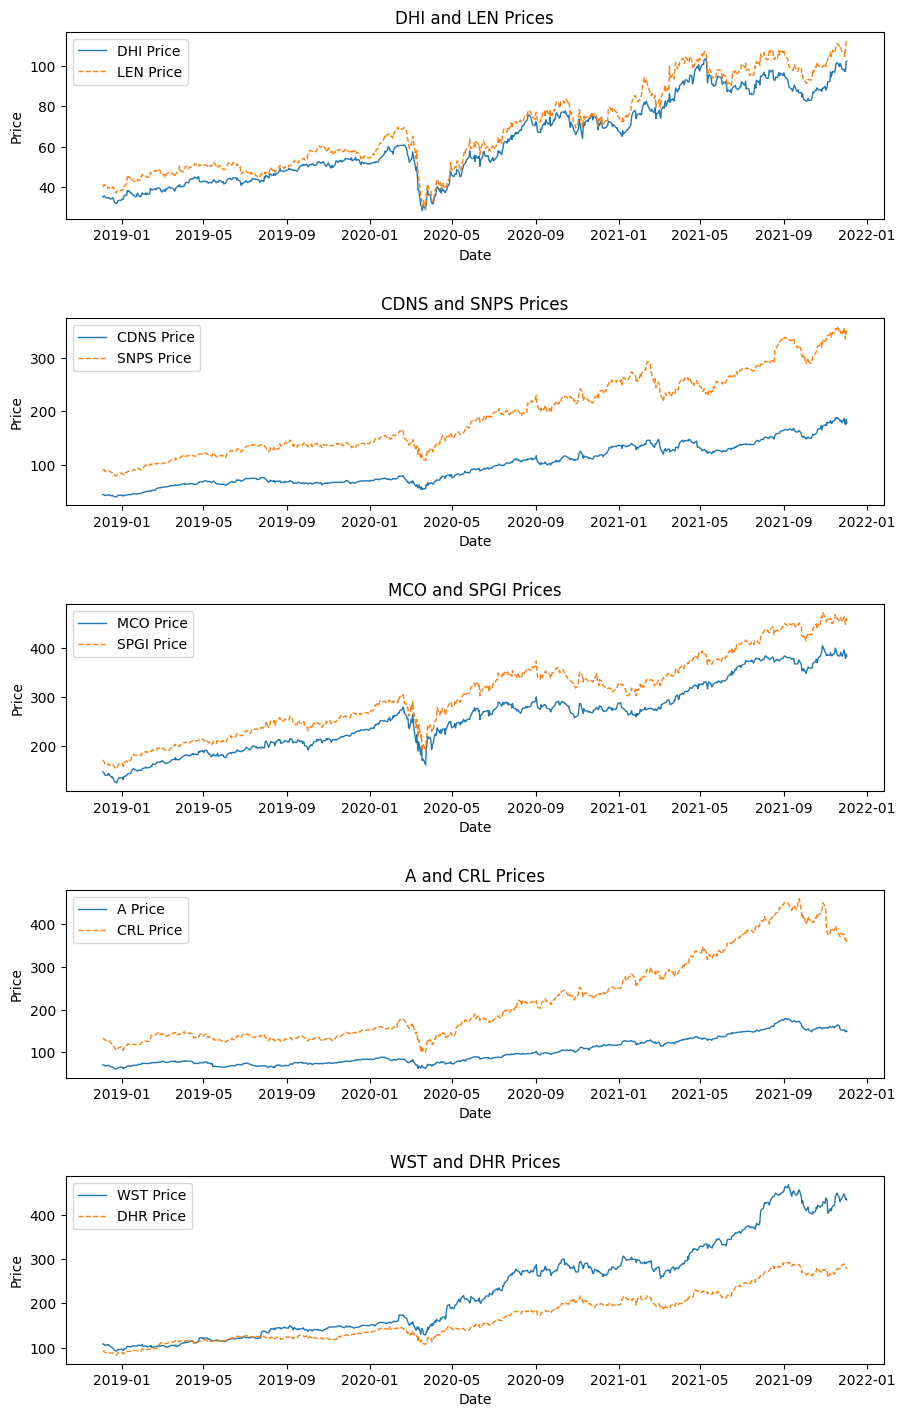

In [287]:
ticker_cor_pairs = [
    ('DHI', 'LEN'),
    ('CDNS', 'SNPS'),
    ('MCO', 'SPGI'),
    ('A', 'CRL'),
    ('WST', 'DHR')
]

fig, axes = plt.subplots(nrows=len(ticker_cor_pairs), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_cor_pairs):
    axes[i].plot(df_pivot[ticker1], label=f'{ticker1} Price', linestyle='-', linewidth=1)
    axes[i].plot(df_pivot[ticker2], label=f'{ticker2} Price', linestyle='--', linewidth=1)
    axes[i].set_title(f'{ticker1} and {ticker2} Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

plt.show()

Пары с сильной корреляцией визуально не представляют серьезной возможности для арибтража, но будут протестированы

In [157]:
df_filled = df_pivot.fillna(method='ffill').fillna(method='bfill')
data_array = df_filled.to_numpy().T 
data_reshaped = data_array.reshape((data_array.shape[0], 1, data_array.shape[1]))

In [264]:
# Применение PCA для уменьшения размерности
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(data_reshaped.reshape(data_reshaped.shape[0], -1))
X_pca_reshaped = X_pca.reshape(X_pca.shape[0], 1, X_pca.shape[1])
kmeans = TimeSeriesKMeans(n_clusters=250, metric="dtw", max_iter=10, random_state=413)
clusters = kmeans.fit_predict(X_pca_reshaped)

silhouette_vals = silhouette_samples(data_reshaped.reshape(data_reshaped.shape[0], -1), clusters)
cluster_metrics = pd.DataFrame(columns=['cluster', 'average_silhouette', 'average_intra_distance'])
for cluster_num in np.unique(clusters):
     cluster_indices = np.where(clusters == cluster_num)[0]
     cluster_silhouette_vals = silhouette_vals[cluster_indices]
     cluster_data = data_reshaped[cluster_indices, :, :].reshape(len(cluster_indices), -1)
     intra_distances = euclidean_distances(cluster_data)
     intra_cluster_distance = np.mean(intra_distances)

     new_row = pd.DataFrame({
         'cluster': [cluster_num],
         'average_silhouette': [np.mean(cluster_silhouette_vals)],
         'average_intra_distance': [intra_cluster_distance]
     })
 
     cluster_metrics = pd.concat([cluster_metrics,new_row], ignore_index=True)
 
sorted_clusters_sil = cluster_metrics.sort_values(by='average_silhouette', ascending=False)
sorted_clusters_intr = cluster_metrics.query('average_intra_distance > 0').sort_values(by='average_intra_distance', ascending=True)
print(cluster_metrics.sample(5))

    cluster  average_silhouette  average_intra_distance
105     147           -0.289339              226.273381
130     179           -0.275185              164.397235
161     216           -0.099481              471.638844
78      101           -0.285549              357.847353
5         5            0.000000                0.000000


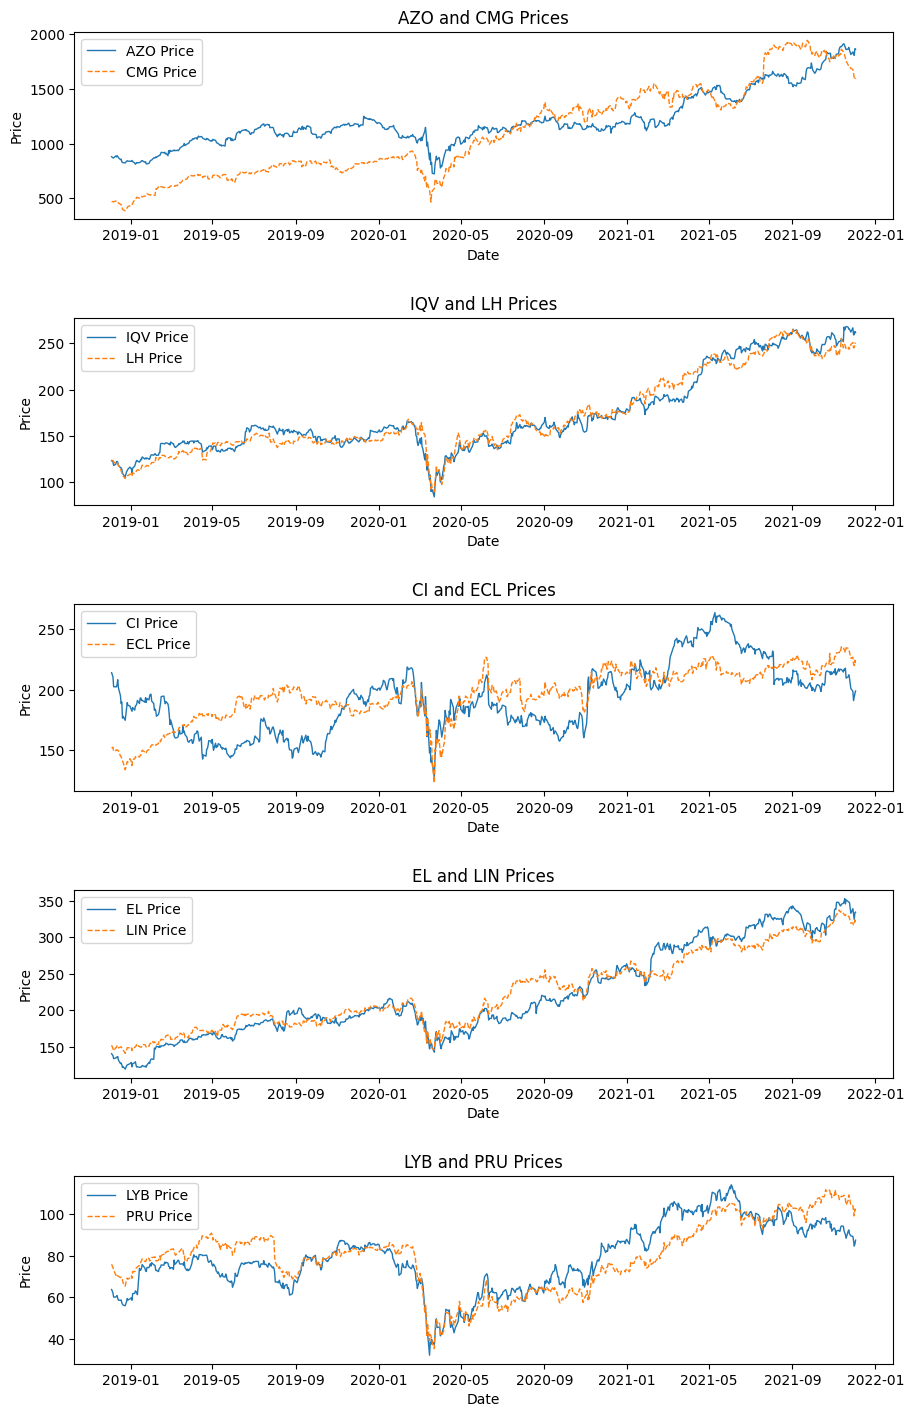

In [265]:
top_clusters_sil = sorted_clusters_sil.head(5)
top_pairs_sil = []

for cluster_num in top_clusters_sil['cluster']:
    cluster_indices = np.where(clusters == cluster_num)[0]
    if len(cluster_indices) >= 2:
        cluster_tickers = df_pivot.columns[cluster_indices]
        pair = cluster_tickers[:2].tolist()
        top_pairs_sil.append(pair)

ticker_pairs_sil = top_pairs_sil[:5]

fig, axes = plt.subplots(nrows=len(ticker_pairs_sil), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs_sil):
    axes[i].plot(df_pivot[ticker1], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot[ticker2], label=f'{ticker2} Price',  linestyle='--', linewidth=1)
    axes[i].set_title(f'{ticker1} and {ticker2} Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

plt.show()

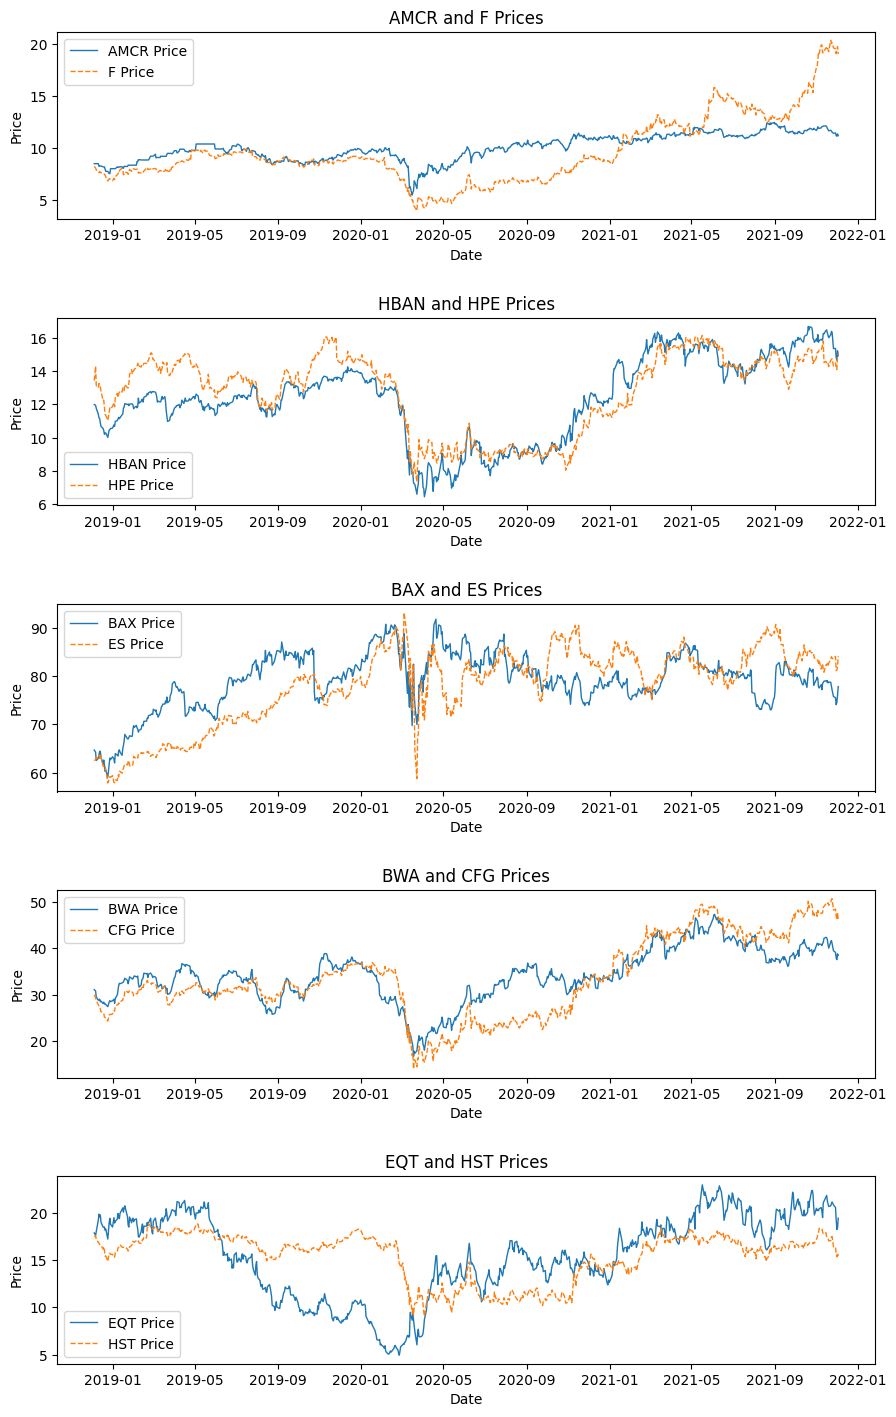

In [266]:
top_clusters_intr = sorted_clusters_intr.head(5)
top_pairs_intr = []

for cluster_num in top_clusters_intr['cluster']:
    cluster_indices = np.where(clusters == cluster_num)[0]
    if len(cluster_indices) >= 2:
        cluster_tickers = df_pivot.columns[cluster_indices]
        pair = cluster_tickers[:2].tolist()
        top_pairs_intr.append(pair)

ticker_pairs_intr = top_pairs_intr[:5]

fig, axes = plt.subplots(nrows=len(ticker_pairs_intr), ncols=1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(ticker_pairs_intr):
    axes[i].plot(df_pivot[ticker1], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot[ticker2], label=f'{ticker2} Price',  linestyle='--', linewidth=1)
    axes[i].set_title(f'{ticker1} and {ticker2} Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

plt.show()

In [161]:
def linear_regression_test(ticker1, ticker2):
    X = df_pivot[ticker1].values.reshape(-1, 1)  # Регрессор
    y = df_pivot[ticker2].values                # Зависимая переменная
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]  # Коэффициент наклона
    intercept = model.intercept_  # Пересечение с осью Y
    return (ticker1, ticker2, coef, intercept)

complete_data_columns = df_pivot.dropna(axis=1).columns

# Генерируем списки пар
pairs = [(complete_data_columns[i], complete_data_columns[j]) 
         for i in range(len(complete_data_columns)) 
         for j in range(i + 1, len(complete_data_columns))]

# Запуск в параллельном режиме
linear_regression_results = Parallel(n_jobs=5)(delayed(linear_regression_test)(pair[0], pair[1]) for pair in pairs)

linear_regression_df = pd.DataFrame(linear_regression_results, columns=['Ticker1', 'Ticker2', 'Coef', 'Intercept'])
linear_regression_df.head()

,Ticker1,Ticker2,Coef,Intercept
0,A,AAL,-0.085355,31.030480
1,A,AAPL,1.137908,-22.684943
2,A,ABBV,0.522065,33.022175
3,A,ABT,0.555875,39.313028
4,A,ACGL,0.064281,29.296897


In [162]:
linear_regression_df.sort_values(by='Coef', ascending=False).head(5)

,Ticker1,Ticker2,Coef,Intercept
12667,AMCR,NVR,552.722883,-1658.986792
12433,AMCR,CMG,277.367510,-1675.137138
79537,HBAN,NVR,219.502023,1158.476604
12649,AMCR,MTD,208.230461,-1121.948318
68755,F,NVR,197.209858,1980.273782


In [164]:
def var_model_test(ticker1, ticker2):
    data = df_pivot[[ticker1, ticker2]].dropna()
    model = VAR(data)
    results = model.fit(maxlags=15, ic='aic')
    return (ticker1, ticker2, results.aic)

complete_data_columns = df_pivot.dropna(axis=1).columns

# Генерируем списки пар
pairs = [(complete_data_columns[i], complete_data_columns[j]) 
         for i in range(len(complete_data_columns)) 
         for j in range(i + 1, len(complete_data_columns))]

# Моделируем VAR в параллельном режиме
var_results = Parallel(n_jobs=5)(delayed(var_model_test)(pair[0], pair[1]) for pair in pairs)

# Преобразование результатов в DataFrame
var_df = pd.DataFrame(var_results, columns=['Ticker1', 'Ticker2', 'AIC'])
var_df.head()

,Ticker1,Ticker2,AIC
0,A,AAL,0.340669
1,A,AAPL,2.048200
2,A,ABBV,1.502644
3,A,ABT,1.484506
4,A,ACGL,0.097884


In [281]:
var_lin_df = pd.merge(linear_regression_df, var_df, on=['Ticker1', 'Ticker2'])
sorted_var_lin_df = var_lin_df.sort_values(by=['Coef', 'AIC'], ascending=[False, True])
top_pairs = sorted_var_lin_df.head(5)
top_lin_pairs = list(top_pairs[['Ticker1', 'Ticker2']].itertuples(index=False, name=None))
print(top_pairs)

      Ticker1 Ticker2        Coef    Intercept       AIC
12667    AMCR     NVR  552.722883 -1658.986792  5.229361
12433    AMCR     CMG  277.367510 -1675.137138  2.682483
79537    HBAN     NVR  219.502023  1158.476604  6.318470
12649    AMCR     MTD  208.230461 -1121.948318  2.057515
68755       F     NVR  197.209858  1980.273782  6.012416


In [165]:
# Функция для проведения теста на коинтеграцию
def cointegration_test(ticker1, ticker2):
    score, p_value, _ = coint(df_pivot[ticker1], df_pivot[ticker2])
    return (ticker1, ticker2, p_value)

complete_data_columns = df_pivot.dropna(axis=1).columns

# Генерируем списки пар
pairs = [(complete_data_columns[i], complete_data_columns[j]) 
         for i in range(len(complete_data_columns)) 
         for j in range(i + 1, len(complete_data_columns))]

# Проведим тесты на коинтеграцию в параллельном режиме
cointegration_results = Parallel(n_jobs=5)(delayed(cointegration_test)(pair[0], pair[1]) for pair in pairs)

cointegration_df = pd.DataFrame(cointegration_results, columns=['Ticker1', 'Ticker2', 'P_Value'])
cointegration_df.head()

,Ticker1,Ticker2,P_Value
0,A,AAL,0.890662
1,A,AAPL,0.414158
2,A,ABBV,0.149337
3,A,ABT,0.246877
4,A,ACGL,0.965324


In [261]:
cointegration_df.query('P_Value < 0.00001')

,Ticker1,Ticker2,P_Value
9237,AKAM,EQIX,0.000006
25827,BDX,CME,0.000007
25830,BDX,CMS,0.000003
25893,BDX,ETR,0.000001
25997,BDX,LHX,0.000010
38518,CFG,MGM,0.000006
92317,KLAC,MCK,0.000008
100179,MGM,WAB,0.000009


In [275]:
coint_list_1 = list(cointegration_df.query('P_Value < 0.00001')[['Ticker1', 'Ticker2']].itertuples(index=False, name=None))

In [263]:
cointegration_df.query('P_Value < 0.01').sample(3, random_state=413)

,Ticker1,Ticker2,P_Value
74836,GEN,L,0.006614
89453,JBHT,LOW,0.001839
33748,CAH,SWKS,0.001292


In [276]:
coint_list_2 = list(cointegration_df.query('P_Value < 0.01').sample(3, random_state=413)[['Ticker1', 'Ticker2']].itertuples(index=False, name=None))

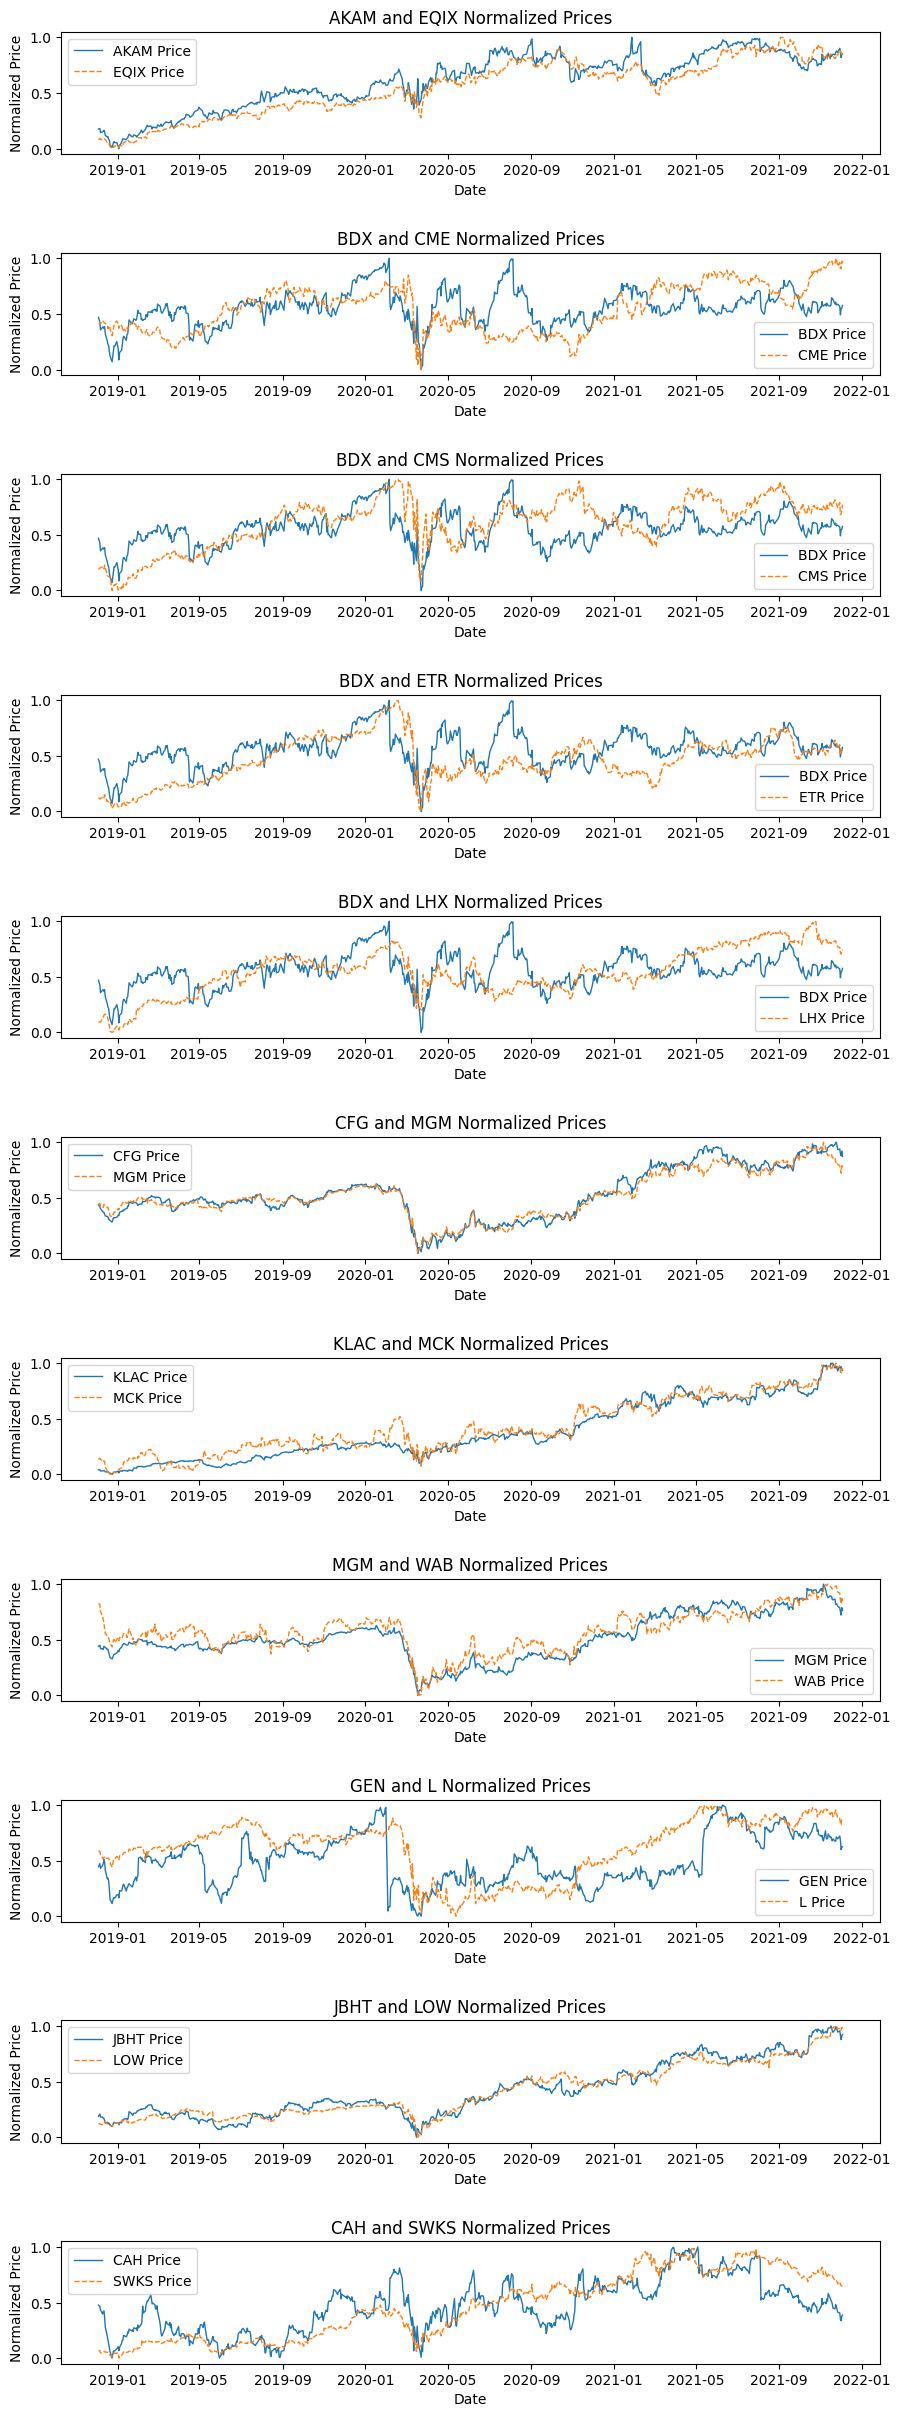

In [280]:
scaler = MinMaxScaler()

top_pairs_coint  = coint_list_1 + coint_list_2

fig, axes = plt.subplots(nrows=len(top_pairs_coint), ncols=1, figsize=(10, 25))
fig.tight_layout(pad=5.0)

for i, (ticker1, ticker2) in enumerate(top_pairs_coint):
    scaled_prices = scaler.fit_transform(df_pivot[[ticker1, ticker2]])
    axes[i].plot(df_pivot.index, scaled_prices[:, 0], label=f'{ticker1} Price',  linestyle='-', linewidth=1)
    axes[i].plot(df_pivot.index, scaled_prices[:, 1], label=f'{ticker2} Price',  linestyle='--', linewidth=1)

    axes[i].set_title(f'{ticker1} and {ticker2} Normalized Prices')
    axes[i].legend()
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Normalized Price')

plt.show()

In [294]:
pre_final_pairs = ticker_cor_pairs + top_pairs_sil + top_pairs_intr + top_lin_pairs + top_pairs_coint
pre_final_pairs

[('DHI', 'LEN'),
 ('CDNS', 'SNPS'),
 ('MCO', 'SPGI'),
 ('A', 'CRL'),
 ('WST', 'DHR'),
 ['AZO', 'CMG'],
 ['IQV', 'LH'],
 ['CI', 'ECL'],
 ['EL', 'LIN'],
 ['LYB', 'PRU'],
 ['AMCR', 'F'],
 ['HBAN', 'HPE'],
 ['BAX', 'ES'],
 ['BWA', 'CFG'],
 ['EQT', 'HST'],
 ('AMCR', 'NVR'),
 ('AMCR', 'CMG'),
 ('HBAN', 'NVR'),
 ('AMCR', 'MTD'),
 ('F', 'NVR'),
 ('AKAM', 'EQIX'),
 ('BDX', 'CME'),
 ('BDX', 'CMS'),
 ('BDX', 'ETR'),
 ('BDX', 'LHX'),
 ('CFG', 'MGM'),
 ('KLAC', 'MCK'),
 ('MGM', 'WAB'),
 ('GEN', 'L'),
 ('JBHT', 'LOW'),
 ('CAH', 'SWKS')]

In [335]:
def test_stationarity(df_pivot, ticker1, ticker2):
    spread = df_pivot[ticker1] - df_pivot[ticker2]
    result = adfuller(spread.dropna(), autolag='AIC')
    p_value = result[1]
    return (ticker1, ticker2, p_value)

# Результаты теста на стационарность для каждой пары тикеров
stationarity_results = [test_stationarity(df_pivot, pair[0], pair[1]) for pair in pre_final_pairs]
stationarity_df = pd.DataFrame(stationarity_results, columns=['Ticker1', 'Ticker2', 'pval'])
final_pairs = stationarity_df.query('pval < 0.05').head(2)
final_pairs

,Ticker1,Ticker2,pval
0,DHI,LEN,0.009150
6,IQV,LH,0.000447


In [336]:
final_pairs_list = list(final_pairs[['Ticker1', 'Ticker2']].itertuples(index=False, name=None))

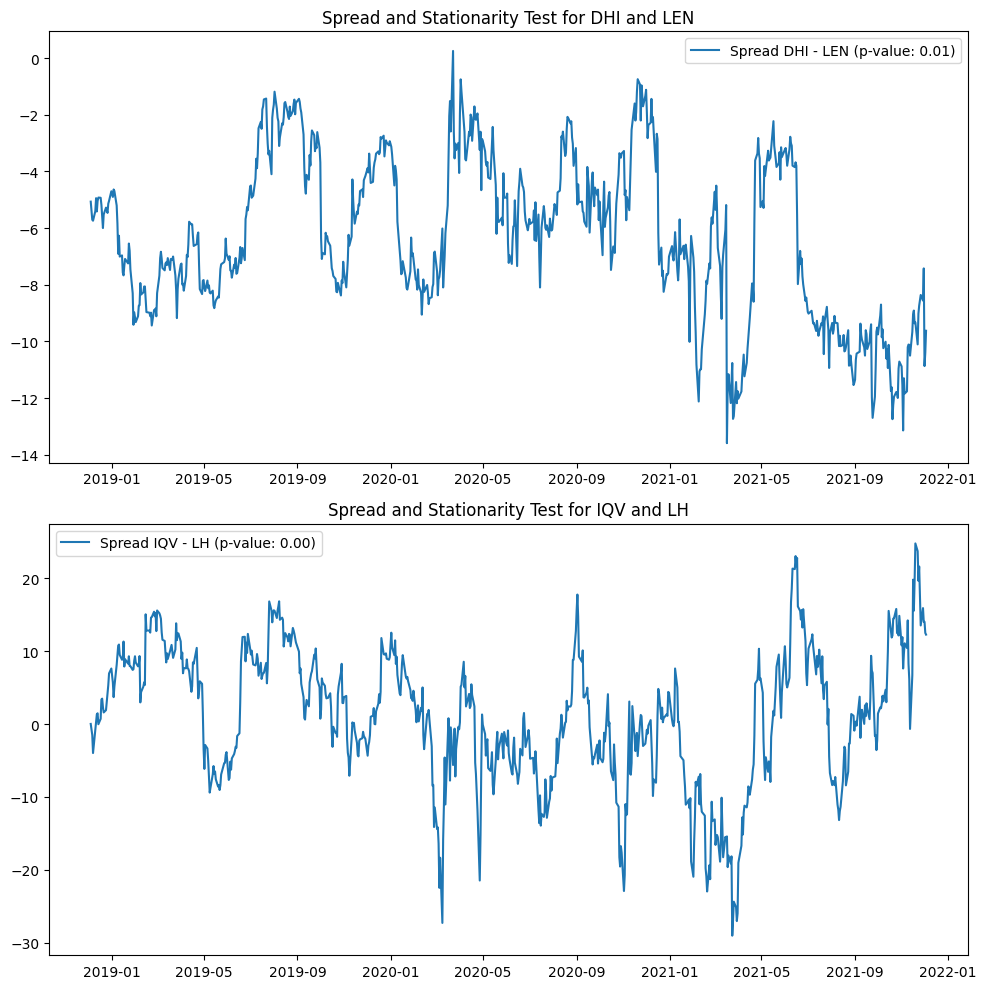

In [337]:
fig, axes = plt.subplots(len(final_pairs_list), 1, figsize=(10, 5 * len(final_pairs_list)))

for i, pair in enumerate(final_pairs_list):
    spread = df_pivot[pair[0]] - df_pivot[pair[1]]
    result = adfuller(spread.dropna(), autolag='AIC')
    p_value = result[1]
    axes[i].plot(spread, label=f'Spread {pair[0]} - {pair[1]} (p-value: {p_value:.2f})')
    axes[i].legend()
    axes[i].set_title(f'Spread and Stationarity Test for {pair[0]} and {pair[1]}')

plt.tight_layout()
plt.show()

In [338]:
def test_pair_trading_strategy_enhanced(valid_df, ticker1, ticker2, initial_capital, entry_multiplier, exit_multiplier):
    # Создание сводной таблицы для цен открытия и закрытия
    df_open = valid_df.pivot(index='date', columns='ticker', values='open')
    df_close = valid_df.pivot(index='date', columns='ticker', values='close')

    # Расчет логарифмического спреда и стационарности
    log_spread = np.log(df_close[ticker1]) - np.log(df_close[ticker2])
    mean_log_spread = log_spread.mean()
    std_log_spread = log_spread.std()
    adf_result = adfuller(log_spread.dropna())
    p_value = adf_result[1]

    # Пороги для открытия и закрытия позиций
    entry_threshold = std_log_spread * entry_multiplier
    exit_threshold = std_log_spread * exit_multiplier

    position = 0  # 1 для long ticker1, -1 для short ticker1
    capital = initial_capital
    capital_history = [capital]
    trade_history = []
    trade_count = 0

    for i in range(1, len(log_spread)):
        if log_spread[i-1] > mean_log_spread + entry_threshold and position == 0:
            position = -1
            trade_history.append((df_close.index[i], 'Enter Short'))
            trade_count += 1
        elif log_spread[i-1] < mean_log_spread - entry_threshold and position == 0:
            position = 1
            trade_history.append((df_close.index[i], 'Enter Long'))
            trade_count += 1
        elif abs(log_spread[i-1] - mean_log_spread) < exit_threshold and position != 0:
            position = 0
            trade_history.append((df_close.index[i], 'Exit'))
            trade_count += 1

        if position != 0:
            daily_return = position * (np.log(df_close[ticker1].iloc[i]) - np.log(df_open[ticker1].iloc[i])) \
                         - position * (np.log(df_close[ticker2].iloc[i]) - np.log(df_open[ticker2].iloc[i]))
            capital += daily_return * capital
        capital_history.append(capital)

    # Графики
    plt.figure(figsize=(15, 10))

    # График котировок
    plt.subplot(3, 1, 1)
    plt.plot(df_close[ticker1], label=ticker1)
    plt.plot(df_close[ticker2], label=ticker2)
    plt.title(f'Prices of {ticker1} and {ticker2}')
    plt.legend()

    # График спреда
    plt.subplot(3, 1, 2)
    plt.plot(log_spread, label='Log Spread')
    plt.axhline(mean_log_spread, color='black', linestyle='--', label='Mean')
    plt.axhline(mean_log_spread + entry_threshold, color='red', linestyle='--', label='ENTRY Threshold')
    plt.axhline(mean_log_spread - entry_threshold, color='red', linestyle='--', label='ENTRY Threshold')
    plt.axhline(mean_log_spread + exit_threshold, color='blue', linestyle='-.', label='EXIT Threshold')
    plt.axhline(mean_log_spread - exit_threshold, color='blue', linestyle='-.', label='EXIT Threshold')
    plt.title('Log Spread and Trading Signals')
    plt.legend()

    # График капитала
    plt.subplot(3, 1, 3)
    plt.plot(capital_history, label='Capital')
    plt.title('Capital Growth')
    plt.xlabel('Time')
    plt.ylabel('Capital in $')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Расчет доходности и вывод результатов
    final_capital = capital_history[-1]
    return_rate = (final_capital - initial_capital) / initial_capital * 100
    print(f"Number of Trades: {trade_count}")
    print(f"Final Capital: {final_capital:.2f}")
    print(f"Return Rate: {return_rate:.2f}%")
    print(f"ADF p-value: {p_value:.4f}")

    return capital_history, trade_history, trade_count

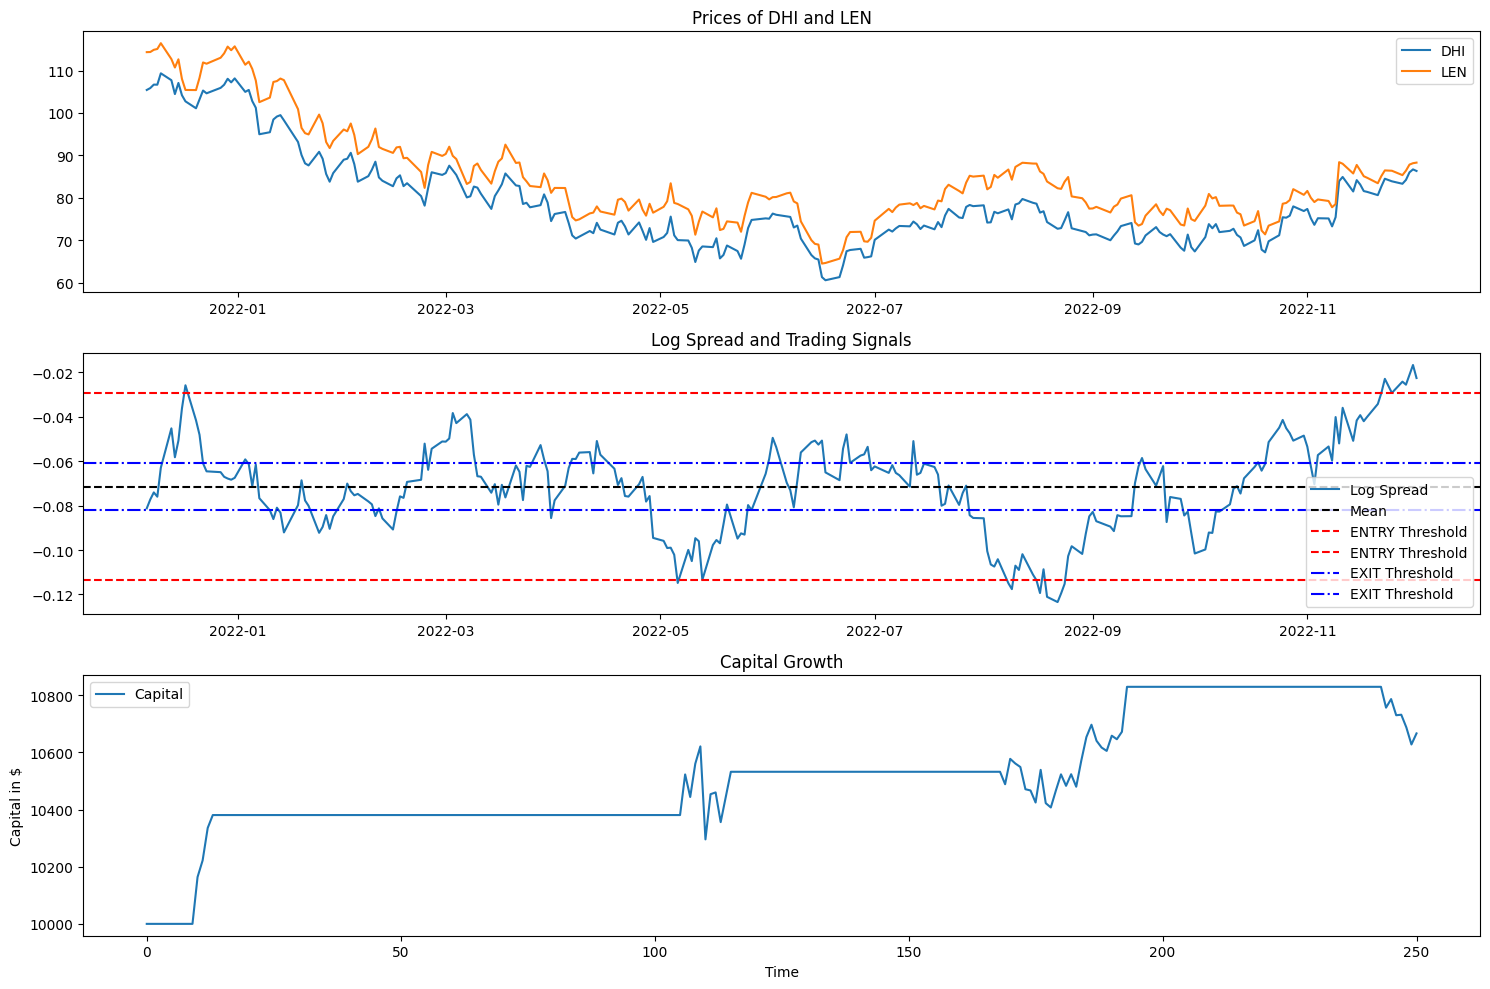

Number of Trades: 7
Final Capital: 10666.49
Return Rate: 6.66%
ADF p-value: 0.2137


In [339]:
ticker1, ticker2 = final_pairs_list[0]
capital_history, trade_history, trade_count = test_pair_trading_strategy_enhanced(valid_df, ticker1, ticker2, 10000, 2, 0.5)

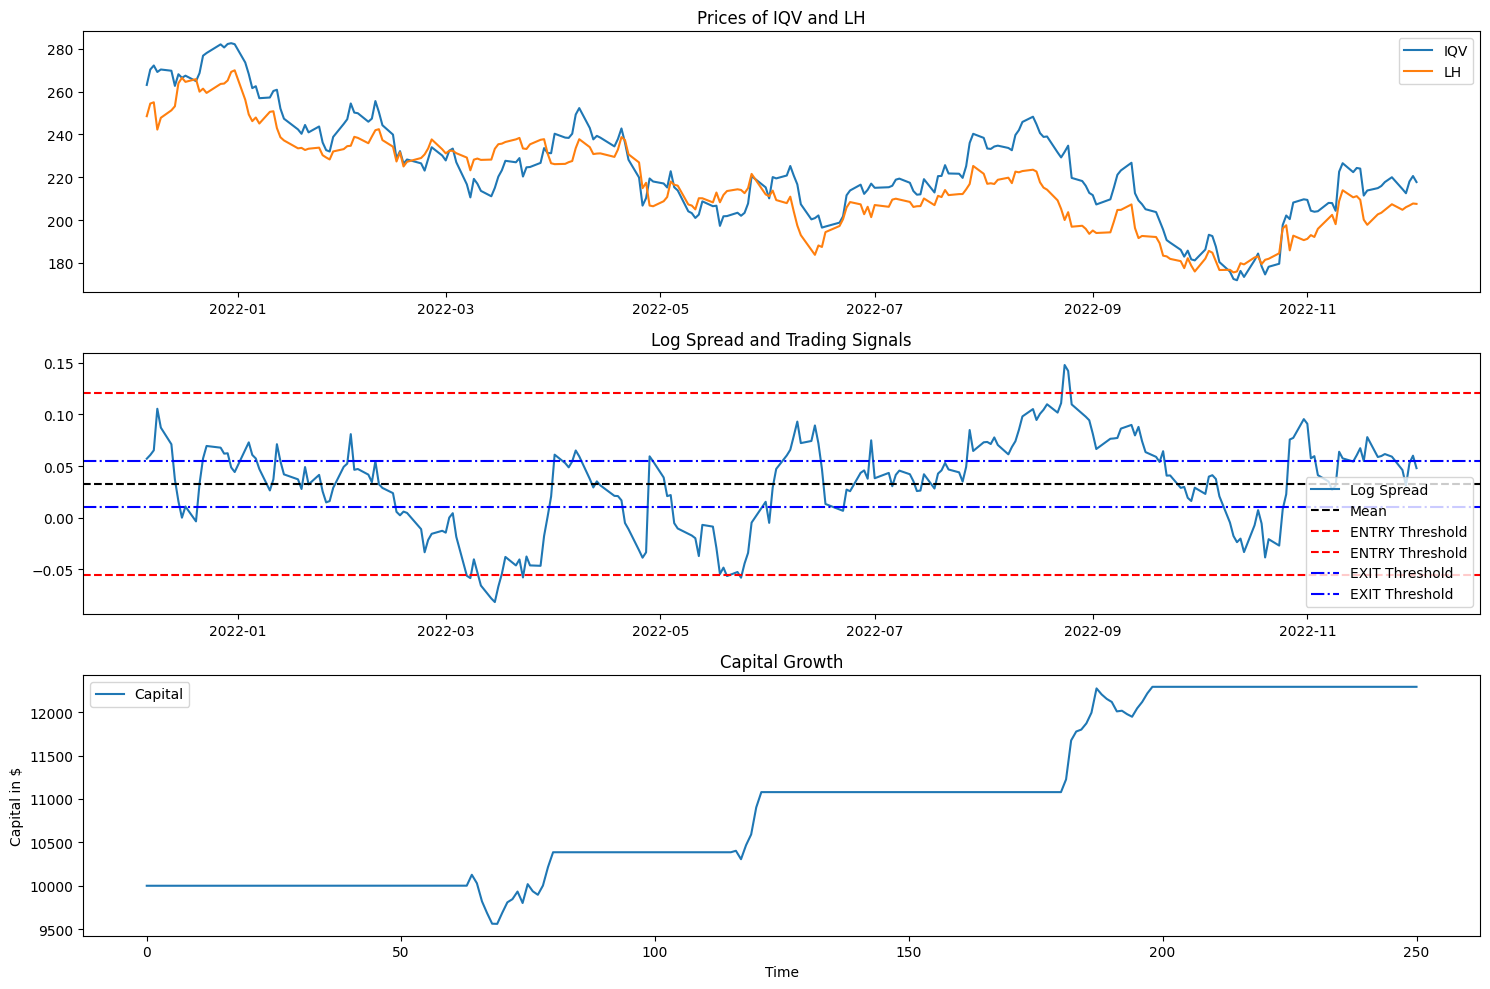

Number of Trades: 6
Final Capital: 12292.78
Return Rate: 22.93%
ADF p-value: 0.0273


In [340]:
ticker1, ticker2 = final_pairs_list[1]
capital_history, trade_history, trade_count = test_pair_trading_strategy_enhanced(valid_df, ticker1, ticker2, 10000, 2, 0.5)

In [341]:
def find_optimal_strategy(valid_df, ticker1, ticker2, initial_capital, entry_multiplier_range, exit_multiplier_range):
    df_open = valid_df.pivot(index='date', columns='ticker', values='open')
    df_close = valid_df.pivot(index='date', columns='ticker', values='close')
    log_spread = np.log(df_close[ticker1]) - np.log(df_close[ticker2])

    best_return_rate = -np.inf
    best_strategy = None

    for entry_multiplier in entry_multiplier_range:
        for exit_multiplier in exit_multiplier_range:
            mean_log_spread = log_spread.mean()
            std_log_spread = log_spread.std()
            entry_threshold = std_log_spread * entry_multiplier
            exit_threshold = std_log_spread * exit_multiplier

            position = 0
            capital = initial_capital
            capital_history = [capital]

            for i in range(1, len(log_spread)):
                if log_spread[i-1] > mean_log_spread + entry_threshold and position == 0:
                    position = -1
                elif log_spread[i-1] < mean_log_spread - entry_threshold and position == 0:
                    position = 1
                elif abs(log_spread[i-1] - mean_log_spread) < exit_threshold and position != 0:
                    position = 0

                if position != 0:
                    daily_return = position * (np.log(df_close[ticker1].iloc[i]) - np.log(df_open[ticker1].iloc[i])) \
                                 - position * (np.log(df_close[ticker2].iloc[i]) - np.log(df_open[ticker2].iloc[i]))
                    capital += daily_return * capital
                capital_history.append(capital)

            final_capital = capital_history[-1]
            return_rate = (final_capital - initial_capital) / initial_capital * 100

            if return_rate > best_return_rate:
                best_return_rate = return_rate
                best_strategy = (entry_multiplier, exit_multiplier, return_rate)

    return best_strategy

In [343]:
for i in range(2):
    ticker1, ticker2 = final_pairs_list[i]
    entry_multiplier_range = np.arange(1, 3, 0.25)
    exit_multiplier_range = np.arange(0.2, 1, 0.1)
    initial_capital = 10000
    # Поиск наилучшей стратегии
    best_strategy = find_optimal_strategy(valid_df, ticker1, ticker2, initial_capital, entry_multiplier_range, exit_multiplier_range)
    print(f"{ticker1},{ticker2} Best Strategy: Entry Multiplier: {best_strategy[0]}, Exit Multiplier: {best_strategy[1]}, Return Rate: {best_strategy[2]}%")

DHI,LEN Best Strategy: Entry Multiplier: 1.0, Exit Multiplier: 0.4000000000000001, Return Rate: 15.32022287043279%
IQV,LH Best Strategy: Entry Multiplier: 1.25, Exit Multiplier: 0.7000000000000002, Return Rate: 30.452623492556125%


Окончательный тест на тестовом временном ряде c окном расчета отклонения спреда (без подглядывания)

In [344]:
result_return_list = []

In [345]:
def test_pair_trading_strategy_final(test_df, valid_df, ticker1, ticker2, initial_capital, entry_multiplier, exit_multiplier):
    # Создание сводной таблицы для цен открытия и закрытия
    df_open = test_df.pivot(index='date', columns='ticker', values='open')
    df_close = test_df.pivot(index='date', columns='ticker', values='close')
    df_open_val = valid_df.pivot(index='date', columns='ticker', values='open')
    df_close_val = valid_df.pivot(index='date', columns='ticker', values='close')
    
    # Расчет логарифмического спреда и стационарности
    log_spread = np.log(df_close[ticker1]) - np.log(df_close[ticker2])
    log_spread_val = np.log(df_close_val[ticker1]) - np.log(df_close_val[ticker2])
    
    mean_log_spread = log_spread_val.mean()
    std_log_spread = log_spread_val.std()
    adf_result = adfuller(log_spread.dropna())
    p_value = adf_result[1]

    # Пороги для открытия и закрытия позиций
    entry_threshold = std_log_spread * entry_multiplier
    exit_threshold = std_log_spread * exit_multiplier

    position = 0  # 1 для long ticker1, -1 для short ticker1
    capital = initial_capital
    capital_history = [capital]
    trade_history = []
    trade_count = 0

    for i in range(1, len(log_spread)):
        if log_spread[i-1] > mean_log_spread + entry_threshold and position == 0:
            position = -1
            trade_history.append((df_close.index[i], 'Enter Short'))
            trade_count += 1
        elif log_spread[i-1] < mean_log_spread - entry_threshold and position == 0:
            position = 1
            trade_history.append((df_close.index[i], 'Enter Long'))
            trade_count += 1
        elif abs(log_spread[i-1] - mean_log_spread) < exit_threshold and position != 0:
            position = 0
            trade_history.append((df_close.index[i], 'Exit'))
            trade_count += 1

        if position != 0:
            daily_return = position * (np.log(df_close[ticker1].iloc[i]) - np.log(df_open[ticker1].iloc[i])) \
                         - position * (np.log(df_close[ticker2].iloc[i]) - np.log(df_open[ticker2].iloc[i]))
            capital += daily_return * capital
        capital_history.append(capital)
        
        log_spread_val = log_spread_val.shift(-1)  
        log_spread_val.iloc[-1] = log_spread.iloc[i]  
        mean_log_spread = log_spread_val.mean()
        std_log_spread = log_spread_val.std()
        entry_threshold = std_log_spread * entry_multiplier
        exit_threshold = std_log_spread * exit_multiplier
    
    # Графики
    plt.figure(figsize=(15, 10))

    # График котировок
    plt.subplot(3, 1, 1)
    plt.plot(df_close[ticker1], label=ticker1)
    plt.plot(df_close[ticker2], label=ticker2)
    plt.title(f'Prices of {ticker1} and {ticker2}')
    plt.legend()

    # График спреда
    plt.subplot(3, 1, 2)
    plt.plot(log_spread, label='Log Spread')
    plt.axhline(mean_log_spread, color='black', linestyle='--', label='Mean')
    plt.axhline(mean_log_spread + entry_threshold, color='red', linestyle='--', label='ENTRY Threshold')
    plt.axhline(mean_log_spread - entry_threshold, color='red', linestyle='--', label='ENTRY Threshold')
    plt.title('Log Spread and Trading Signals')
    plt.legend()

    # График капитала
    plt.subplot(3, 1, 3)
    plt.plot(capital_history, label='Capital')
    plt.title('Capital Growth')
    plt.xlabel('Time')
    plt.ylabel('Capital in $')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Расчет доходности и вывод результатов
    final_capital = capital_history[-1]
    return_rate = (final_capital - initial_capital) / initial_capital * 100
    print(f"Number of Trades: {trade_count}")
    print(f"Final Capital: {final_capital:.2f}")
    print(f"Return Rate: {return_rate:.2f}%")
    print(f"ADF p-value: {p_value:.4f}")

    return capital_history, trade_history, trade_count

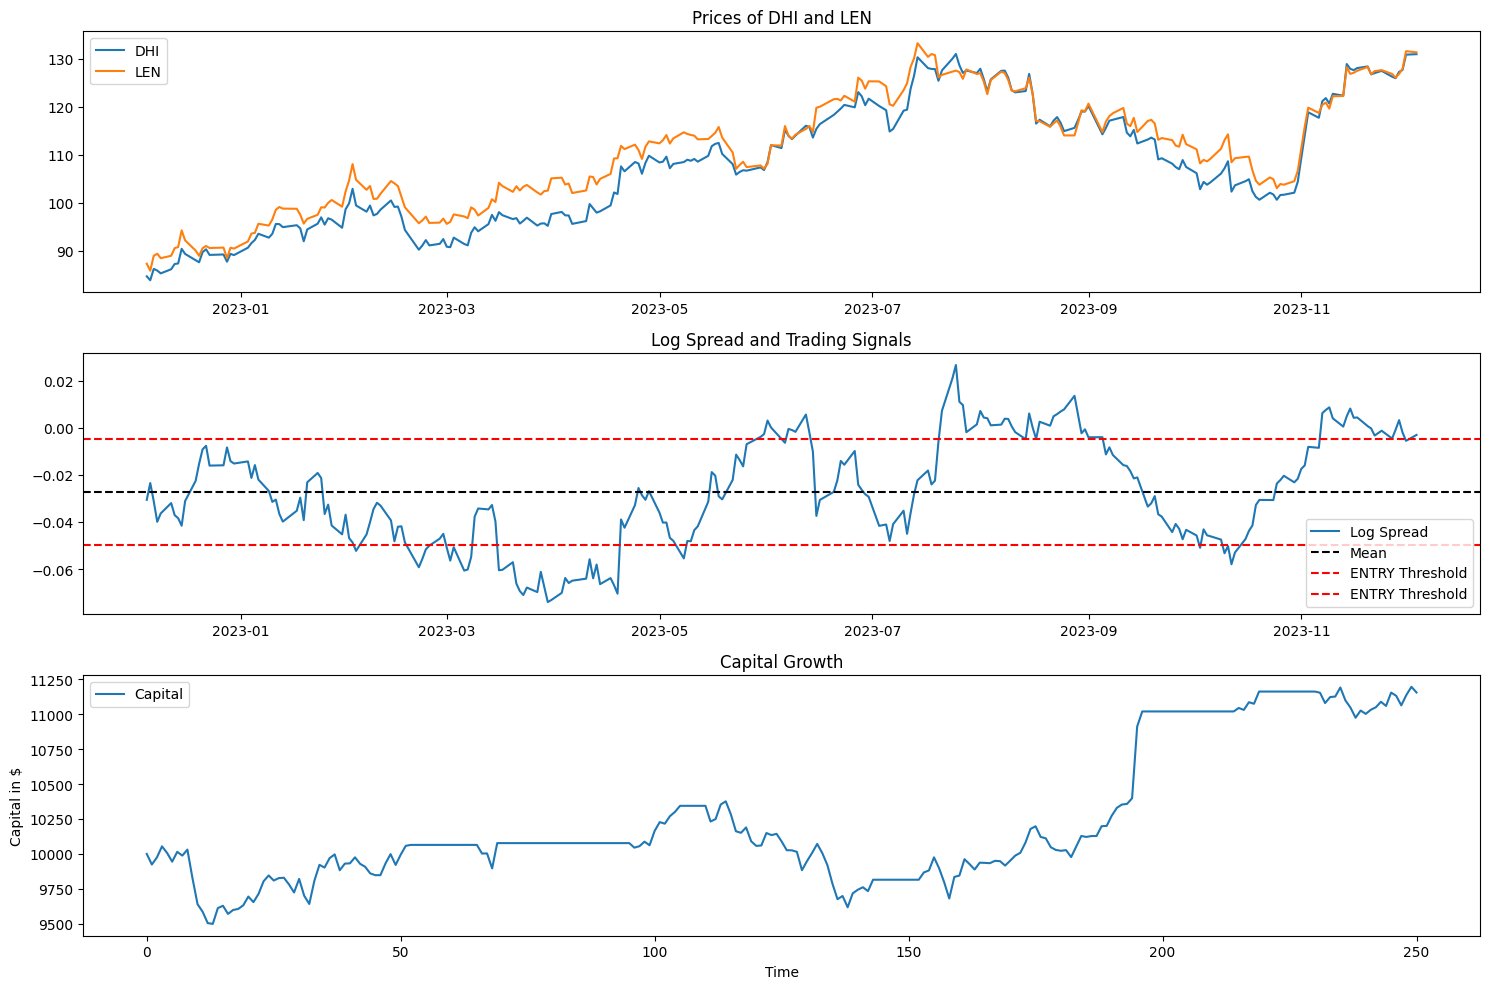

Number of Trades: 13
Final Capital: 11154.34
Return Rate: 11.54%
ADF p-value: 0.1996


In [346]:
result_return_list = []
ticker1, ticker2 = final_pairs_list[0]
capital_history, trade_history, trade_count = test_pair_trading_strategy_final(test_df, valid_df, ticker1, ticker2, 10000, 1, 0.4)
result_return_list.append(capital_history[-1])

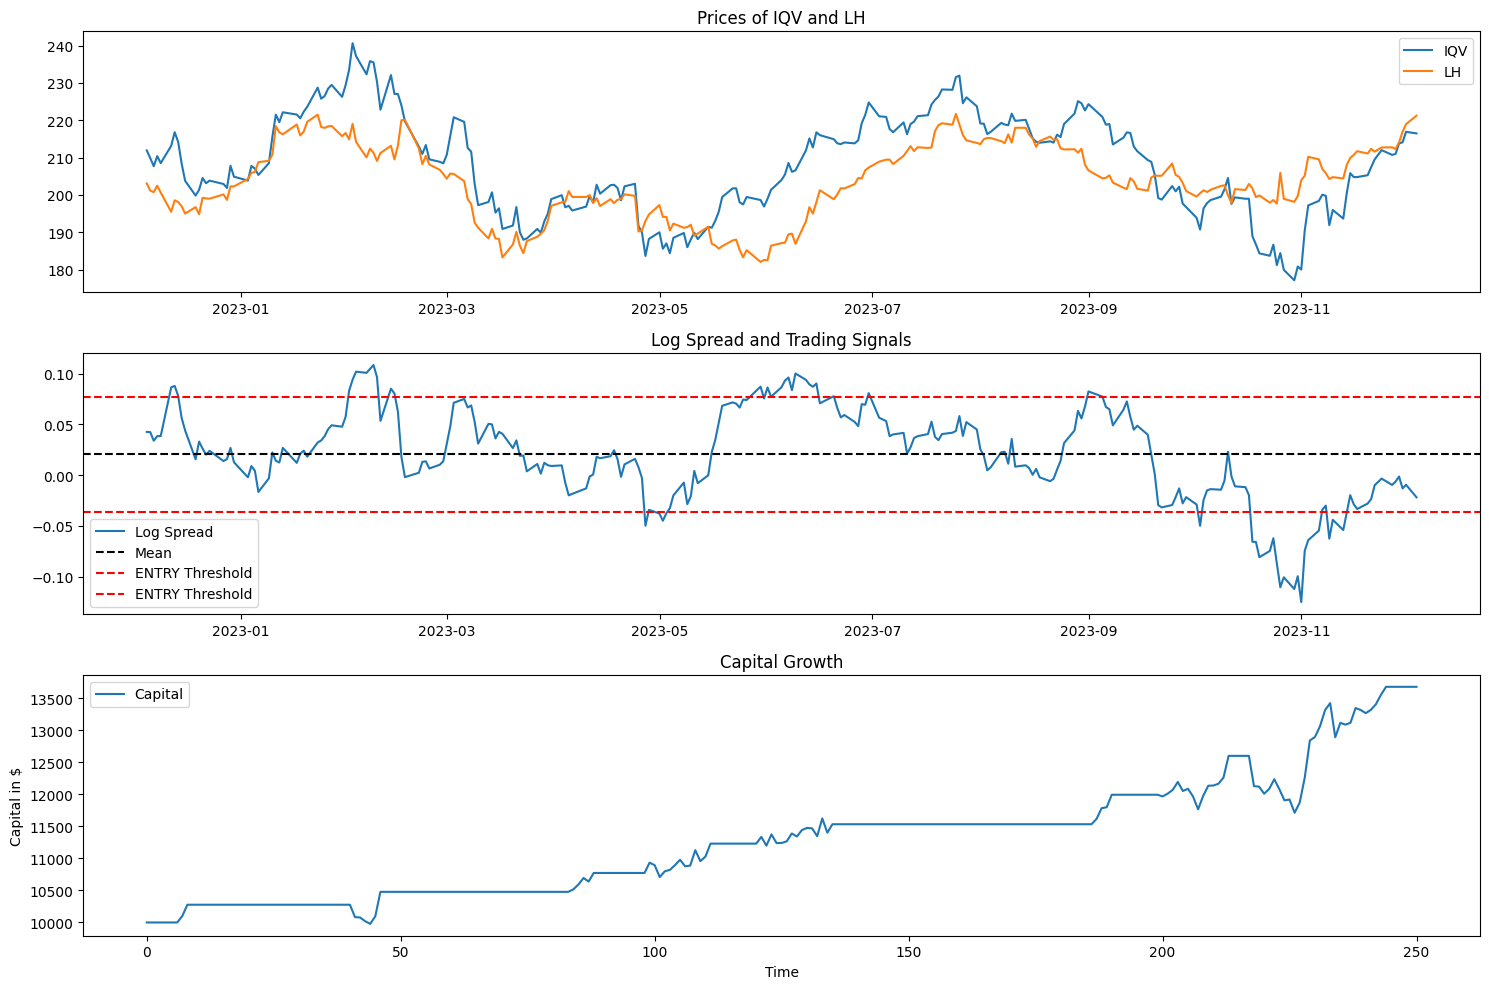

Number of Trades: 16
Final Capital: 13679.04
Return Rate: 36.79%
ADF p-value: 0.1234


In [347]:
ticker1, ticker2 = final_pairs_list[1]
capital_history, trade_history, trade_count = test_pair_trading_strategy_final(test_df, valid_df, ticker1, ticker2, 10000, 1.25, 0.7)
result_return_list.append(capital_history[-1])

In [350]:
f"Общая доходность без учета комиссий за сделку и шорт {round(100*(sum(result_return_list)/ 20000 - 1),2)}%"

'Общая доходность без учета комиссий за сделку и шорт 24.17%'